In [1]:
pip install opencv-python 

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashe23","key":"071f1ef3174b6802ae9ff6b4a6ec7d8a"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d puneet6060/intel-image-classification

100% 345M/346M [00:03<00:00, 126MB/s]
100% 346M/346M [00:03<00:00, 105MB/s]


In [9]:
!unzip -uq "/content/intel-image-classification.zip" -d "/content/intel-image-classification"

In [33]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from keras.optimizers import SGD
from tensorflow.keras import applications
from tensorflow.keras.layers import LeakyReLU
#import efficientnet
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras.models import Sequential

In [11]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 4.6MB/s 


In [12]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [13]:
class_names_label

{'buildings': 3,
 'forest': 5,
 'glacier': 2,
 'mountain': 0,
 'sea': 4,
 'street': 1}

## Loading the data

In [15]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['../content/intel-image-classification/seg_train/seg_train', '/content/intel-image-classification/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets and pred sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output
        

In [16]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  4%|▍         | 100/2382 [00:00<00:02, 996.76it/s]

Loading ../content/intel-image-classification/seg_train/seg_train


 38%|███▊      | 192/501 [00:00<00:00, 1914.79it/s]

Loading /content/intel-image-classification/seg_test/seg_test


100%|██████████| 474/474 [00:00<00:00, 1638.20it/s]


In [17]:
train_images[0].shape

(150, 150, 3)

In [18]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=7)

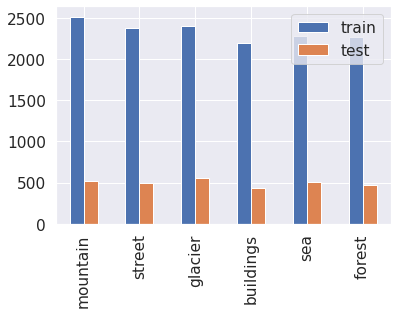

In [19]:
train_labels_unique, train_counts = np.unique(train_labels, return_counts=True)
test_labels_unique, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

## Explore Dataset

In [20]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image -RGB  shape is: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image -RGB  shape is: (150, 150)


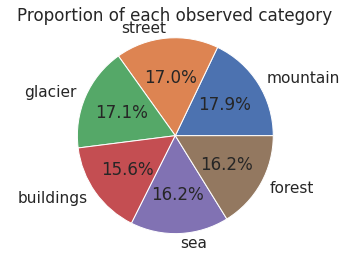

In [21]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

### Data Visualization

In [22]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [24]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

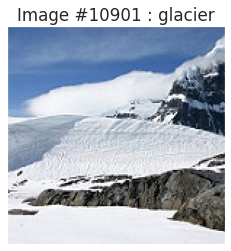

In [25]:
display_random_image(class_names, train_images, train_labels)

In [26]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

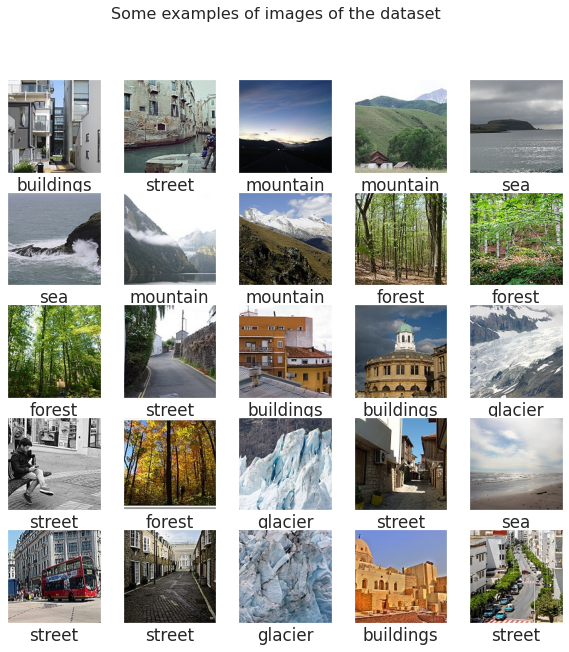

In [27]:
display_examples(class_names, train_images, train_labels)

In [28]:
def plot_accuracy_loss(history,model_name):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc" + model_name)
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss"  + model_name)
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

## Models

**Models Without Transfer Learning**
### Model 1

In [93]:
epochs = 25
learning_rate = 0.1 # initial learning rate
decay_rate = learning_rate/epochs
momentum = 0.08

# define the optimizer function
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

batch_size = 196

# build the model
model_exp = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = tf.nn.relu, input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_initializer='uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, kernel_initializer='uniform', activation=tf.nn.softmax)
    ])

# compile the model
model_exp.compile(loss='sparse_categorical_crossentropy', 
                                optimizer=sgd, 
                                metrics=['accuracy'])
                                
# define the momentum rate change 
def exp_decay(epoch):
    momentum_new = momentum * np.exp(-decay_rate*epoch)
    return momentum_new
    
# learning schedule callback
loss_history = History()
mom_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, mom_rate]

# you invoke the LearningRateScheduler during the .fit() phase
model_exp_history = model_exp.fit(train_images, train_labels,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    verbose=1,
                                    validation_split= 0.25)

Epoch 1/25
54/54 [==============================] - 7s 121ms/step - loss: 1.7831 - accuracy: 0.2004 - val_loss: 1.7629 - val_accuracy: 0.2055
Epoch 2/25
54/54 [==============================] - 6s 115ms/step - loss: 1.6756 - accuracy: 0.3105 - val_loss: 1.4648 - val_accuracy: 0.4406
Epoch 3/25
54/54 [==============================] - 6s 115ms/step - loss: 1.4698 - accuracy: 0.4321 - val_loss: 1.2658 - val_accuracy: 0.5192
Epoch 4/25
54/54 [==============================] - 6s 116ms/step - loss: 1.2877 - accuracy: 0.4945 - val_loss: 1.1685 - val_accuracy: 0.5457
Epoch 5/25
54/54 [==============================] - 6s 117ms/step - loss: 1.1640 - accuracy: 0.5428 - val_loss: 1.1203 - val_accuracy: 0.5557
Epoch 6/25
54/54 [==============================] - 6s 115ms/step - loss: 1.0911 - accuracy: 0.5685 - val_loss: 1.1000 - val_accuracy: 0.5608
Epoch 7/25
54/54 [==============================] - 6s 115ms/step - loss: 1.0416 - accuracy: 0.5904 - val_loss: 1.0255 - val_accuracy: 0.5950
Epoch 

In [94]:
test_loss = model_exp.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 8ms/step - loss: 0.8460 - accuracy: 0.6787


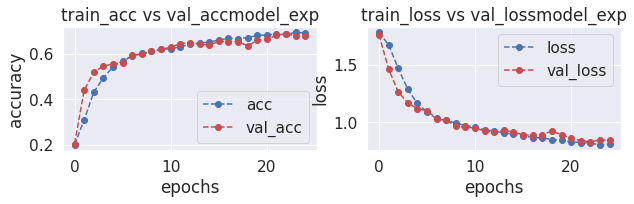

In [95]:
plot_accuracy_loss(model_exp_history,"model_exp")

### Model 2

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [60]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [61]:
historys = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 6s 71ms/step - loss: 1.4226 - accuracy: 0.4898 - val_loss: 0.9053 - val_accuracy: 0.6555
Epoch 2/20
88/88 [==============================] - 6s 63ms/step - loss: 0.8347 - accuracy: 0.6804 - val_loss: 0.7408 - val_accuracy: 0.7300
Epoch 3/20
88/88 [==============================] - 5s 62ms/step - loss: 0.6365 - accuracy: 0.7708 - val_loss: 0.7022 - val_accuracy: 0.7467
Epoch 4/20
88/88 [==============================] - 6s 63ms/step - loss: 0.4859 - accuracy: 0.8270 - val_loss: 0.9002 - val_accuracy: 0.6829
Epoch 5/20
88/88 [==============================] - 6s 63ms/step - loss: 0.3191 - accuracy: 0.8913 - val_loss: 0.7366 - val_accuracy: 0.7538
Epoch 6/20
88/88 [==============================] - 6s 64ms/step - loss: 0.2062 - accuracy: 0.9340 - val_loss: 0.8094 - val_accuracy: 0.7617
Epoch 7/20
88/88 [==============================] - 6s 64ms/step - loss: 0.1217 - accuracy: 0.9662 - val_loss: 0.9085 - val_accuracy: 0.7610
Epoch 8/20
88

In [62]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 8ms/step - loss: 1.3486 - accuracy: 0.7273


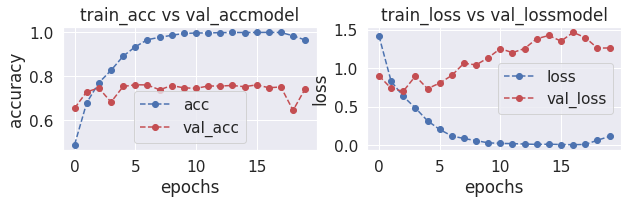

In [64]:
plot_accuracy_loss(historys,"model")

### Model 2

In [65]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])


In [66]:
model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [67]:
historys1 = model1.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 14s 164ms/step - loss: 1.2196 - accuracy: 0.5106 - val_loss: 0.8752 - val_accuracy: 0.6730
Epoch 2/20
88/88 [==============================] - 13s 150ms/step - loss: 0.8911 - accuracy: 0.6581 - val_loss: 0.7249 - val_accuracy: 0.7328
Epoch 3/20
88/88 [==============================] - 13s 152ms/step - loss: 0.7506 - accuracy: 0.7229 - val_loss: 0.6332 - val_accuracy: 0.7788
Epoch 4/20
88/88 [==============================] - 13s 152ms/step - loss: 0.6183 - accuracy: 0.7787 - val_loss: 0.6122 - val_accuracy: 0.7948
Epoch 5/20
88/88 [==============================] - 13s 152ms/step - loss: 0.5206 - accuracy: 0.8122 - val_loss: 0.6076 - val_accuracy: 0.7816
Epoch 6/20
88/88 [==============================] - 13s 151ms/step - loss: 0.3927 - accuracy: 0.8635 - val_loss: 0.5695 - val_accuracy: 0.8037
Epoch 7/20
88/88 [==============================] - 13s 151ms/step - loss: 0.2983 - accuracy: 0.8956 - val_loss: 0.6243 - val_accuracy: 0.7873

In [68]:
test_loss = model1.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 13ms/step - loss: 1.2905 - accuracy: 0.7983


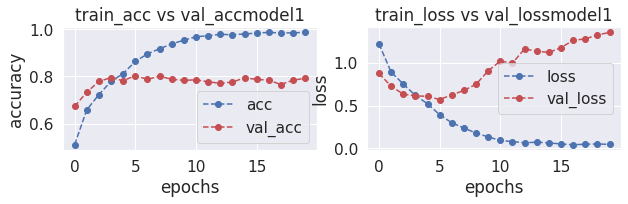

In [69]:
plot_accuracy_loss(historys1,"model1")

### Models using Transfer Learning

### VGG19

In [70]:
model2 = applications.VGG19(weights='imagenet', include_top=False)

train_features = model2.predict(train_images)
test_features = model2.predict(test_images)

80142336/80134624 [==============================] - 1s 0us/step


In [71]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [72]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model3.fit(train_features, train_labels, batch_size=512, epochs=25, validation_split = 0.25)

Epoch 1/25
21/21 [==============================] - 0s 18ms/step - loss: 1.1765 - accuracy: 0.5895 - val_loss: 0.5374 - val_accuracy: 0.8031
Epoch 2/25
21/21 [==============================] - 0s 14ms/step - loss: 0.4577 - accuracy: 0.8362 - val_loss: 0.4277 - val_accuracy: 0.8427
Epoch 3/25
21/21 [==============================] - 0s 13ms/step - loss: 0.3807 - accuracy: 0.8619 - val_loss: 0.3920 - val_accuracy: 0.8561
Epoch 4/25
21/21 [==============================] - 0s 13ms/step - loss: 0.3337 - accuracy: 0.8835 - val_loss: 0.3753 - val_accuracy: 0.8655
Epoch 5/25
21/21 [==============================] - 0s 13ms/step - loss: 0.3026 - accuracy: 0.8926 - val_loss: 0.3598 - val_accuracy: 0.8738
Epoch 6/25
21/21 [==============================] - 0s 13ms/step - loss: 0.2704 - accuracy: 0.9080 - val_loss: 0.3638 - val_accuracy: 0.8689
Epoch 7/25
21/21 [==============================] - 0s 13ms/step - loss: 0.2529 - accuracy: 0.9144 - val_loss: 0.3591 - val_accuracy: 0.8729
Epoch 8/25
21

In [73]:
test_loss = model3.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 0.3852 - accuracy: 0.8703


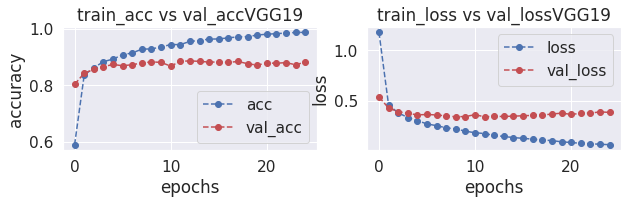

In [74]:
plot_accuracy_loss(history2,"VGG19")

In [77]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(128),
     tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model4.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history3 = model4.fit(train_features, train_labels, batch_size=512, epochs=25, validation_split = 0.25)

Epoch 1/25
21/21 [==============================] - 0s 18ms/step - loss: 1.2674 - accuracy: 0.5275 - val_loss: 0.5249 - val_accuracy: 0.7999
Epoch 2/25
21/21 [==============================] - 0s 13ms/step - loss: 0.6364 - accuracy: 0.7631 - val_loss: 0.4299 - val_accuracy: 0.8376
Epoch 3/25
21/21 [==============================] - 0s 13ms/step - loss: 0.4964 - accuracy: 0.8206 - val_loss: 0.3998 - val_accuracy: 0.8549
Epoch 4/25
21/21 [==============================] - 0s 13ms/step - loss: 0.4348 - accuracy: 0.8450 - val_loss: 0.3651 - val_accuracy: 0.8686
Epoch 5/25
21/21 [==============================] - 0s 13ms/step - loss: 0.3906 - accuracy: 0.8623 - val_loss: 0.3747 - val_accuracy: 0.8635
Epoch 6/25
21/21 [==============================] - 0s 13ms/step - loss: 0.3611 - accuracy: 0.8691 - val_loss: 0.3689 - val_accuracy: 0.8666
Epoch 7/25
21/21 [==============================] - 0s 13ms/step - loss: 0.3381 - accuracy: 0.8806 - val_loss: 0.3444 - val_accuracy: 0.8795
Epoch 8/25
21

In [78]:
test_loss = model4.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8740


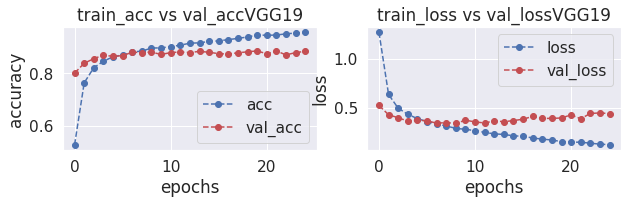

In [79]:
plot_accuracy_loss(history3,"VGG19")

## Models with Image Augmentation

In [80]:
train_path='../content/intel-image-classification/seg_train/seg_train'
test_path='../content/intel-image-classification/seg_test/seg_test'

In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_gen=ImageDataGenerator(rescale=1/255,
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  shear_range=0.2,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest'
                                 )
train_gen=train_data_gen.flow_from_directory(
    train_path,
    target_size=(150,150),
    class_mode='categorical'
)
test_data_gen=ImageDataGenerator(rescale=1/255)
test_gen=test_data_gen.flow_from_directory(
    test_path,
    target_size=(150,150),
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Models Without Transfer Learning

In [82]:
modelIa=tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [83]:
modelIa.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [84]:
historyIa = modelIa.fit_generator(train_gen,validation_data=test_gen, epochs=20)

Epoch 1/20
439/439 [==============================] - 90s 205ms/step - loss: 1.1891 - accuracy: 0.5317 - val_loss: 0.9708 - val_accuracy: 0.6177
Epoch 2/20
439/439 [==============================] - 87s 199ms/step - loss: 0.9803 - accuracy: 0.6216 - val_loss: 1.0131 - val_accuracy: 0.6170
Epoch 3/20
439/439 [==============================] - 85s 195ms/step - loss: 0.8448 - accuracy: 0.6843 - val_loss: 0.6785 - val_accuracy: 0.7610
Epoch 4/20
439/439 [==============================] - 85s 194ms/step - loss: 0.7688 - accuracy: 0.7141 - val_loss: 0.6481 - val_accuracy: 0.7737
Epoch 5/20
439/439 [==============================] - 84s 191ms/step - loss: 0.7199 - accuracy: 0.7373 - val_loss: 0.6213 - val_accuracy: 0.7780
Epoch 6/20
439/439 [==============================] - 83s 190ms/step - loss: 0.6794 - accuracy: 0.7527 - val_loss: 0.5754 - val_accuracy: 0.7913
Epoch 7/20
439/439 [==============================] - 83s 189ms/step - loss: 0.6554 - accuracy: 0.7617 - val_loss: 0.6111 - val_ac

In [85]:
test_loss = modelIa.evaluate(test_gen)

94/94 [==============================] - 3s 35ms/step - loss: 0.5471 - accuracy: 0.8130


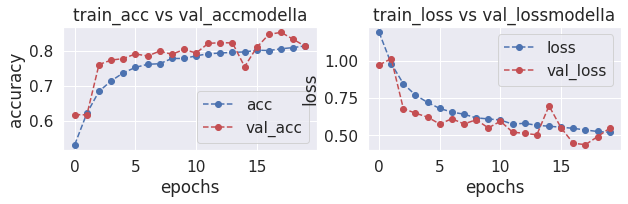

In [86]:
plot_accuracy_loss(historyIa,"modelIa")